In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata
import fastai

# Fast AI Time Series Competition No1: Earthquakes.

Data is already downloaded in `../data/`.

## Data Loading

In [2]:
data_path = pathlib.Path('../data')
batch_size = 128

In [3]:
os.listdir(data_path)

['Earthquakes_TEST.txt',
 'Earthquakes.txt',
 'Earthquakes_TRAIN.arff',
 'GADF',
 'Earthquakes_TRAIN.txt',
 'Earthquakes_TEST.arff']

In [4]:
train = np.loadtxt(data_path/'Earthquakes_TRAIN.txt')
test = np.loadtxt(data_path/'Earthquakes_TEST.txt')

In [5]:
train, train_labels = train[:, 1:], train[:, 0].astype(np.int)
test, test_labels = test[:, 1:], test[:, 0].astype(np.int)

In [6]:
train_ds = torchdata.TensorDataset(
    torch.tensor(train, dtype=torch.float32),
    torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1))
test_ds = torchdata.TensorDataset(
    torch.tensor(test, dtype=torch.float32),
    torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1))

In [7]:
train_dl = torchdata.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = torchdata.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [8]:
data = fastai.DataBunch(train_dl, test_dl)

## LSTM-FCNN
This is a reimplementation of the LSTM-FCNN from https://ieeexplore-ieee-org.ezproxy.cul.columbia.edu/ielx7/6287639/8274985/08141873.pdf?tp=&arnumber=8141873&isnumber=8274985&tag=1

The reported accuracy on the Earthquakes dataset in the paper is .8354.

In [9]:
class ShuffleLSTM(nn.Module):
    def __init__(self, seq_length, dropout=0.0, hidden_size=128, num_layers=1, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size=seq_length,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        ## input size will be the batch, input_size, seq_len =  64, 1, 512
        ## we start with the shuffle layer, transforming this in a 1 step multivariate TS:
        ## output should be 1, 64, 512
        x = torch.transpose(x, 0, 1)
        # input_size, batch, seq_len
        out, (_, _) = self.lstm(x)
        # after the lstm, the output will be 1, bs, lstm_size
        return self.dropout(out)

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, n_channels=128, kernel_size=8, dropout=0.0):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=in_channels,
                             out_channels=n_channels,
                             kernel_size=kernel_size)
        self.bn = nn.BatchNorm1d(num_features=n_channels)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # input size should be batch, input_size, length = 64, 1, 312 at first
        x = self.conv(x)
        # now batch, n_channels, L
        x = self.bn(x)
        x = F.relu(x)
        # output will be bs, n_filters, L (not equal to inital L)
        return self.dropout(x)
    

In [11]:
class LSTM_FCNN(nn.Module):
    def __init__(self,
                 seq_length,
                 lstm_dropout=0.0,
                 lstm_hidden_size=128,
                 lstm_num_layers=1,
                 lstm_bidirectional=False,
                 conv_n_channels = [128, 256, 128],
                 conv_kernel_sizes = [8, 5, 3],
                 conv_dropout=0.0):
        
        super().__init__()
        
        self.lstm = ShuffleLSTM(seq_length,
                                lstm_dropout,
                                lstm_hidden_size,
                                lstm_num_layers,
                                lstm_bidirectional)
        self.convs = []
        
        # global pool is avg pool using the last conv layer's size
        self.global_avg_pool = nn.AvgPool1d(kernel_size = conv_n_channels[-1])
        
        # we set input equal to the previous channel's n
        input_n = 1
        for n_c, k_s in zip(conv_n_channels, conv_kernel_sizes):
            conv = ConvLayer(input_n, n_c, k_s, conv_dropout)
            self.convs.append(conv.cuda())
            input_n = n_c
            
        # for the last FC layer, we need to know how long the TS is after 
        # the convolutional layers
        out_len = seq_length - sum(conv_kernel_sizes) + len(conv_kernel_sizes)
        
        self.linear = nn.Linear(out_len + lstm_hidden_size, 1)
        
        
        
    def forward(self, x):
        # our input is batch, seq_len
        x = x.unsqueeze(1)
        # batch, 1, seq_len
        
        
        lstm_out = self.lstm(x)
        lstm_out = torch.squeeze(lstm_out)
        # lstm_out is bs, lstm_size
        
        for conv_layer in self.convs:
            x = conv_layer(x)
        # x is now bs, dimension, L
        # avgpool1d averages over the last dimension so we transpose again
        x = torch.transpose(x, 1, 2)
        # bs, L, dimension
        x = self.global_avg_pool(x)
        x = torch.squeeze(x)
        # bs, L
        
        concat = torch.cat((lstm_out, x), 1)
        
        return self.linear(concat)


## Training

In [12]:
model = LSTM_FCNN(512, lstm_dropout=0.8, lstm_hidden_size=8)

In [13]:
loss = nn.BCEWithLogitsLoss()
loss = loss.cuda()
# loss = nn.BCEWithLogitsLoss()

In [14]:
def my_acc(pred, targ):
    ok = torch.tensor(torch.abs(torch.sign(pred)/2 + .5 - targ) < .01, dtype=torch.float32)
    return torch.mean(ok)

In [15]:
learner = fastai.Learner(data, model, loss_func=loss, metrics=my_acc)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


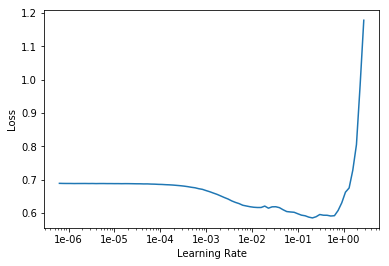

In [16]:
learner.lr_find(); learner.recorder.plot()

In [17]:
learner.fit_one_cycle(30, max_lr=1e-2)

Total time: 00:04
epoch  train_loss  valid_loss  my_acc  
1      0.672288    0.642583    0.748201  (00:00)
2      0.634856    0.578489    0.748201  (00:00)
3      0.582353    0.563130    0.748201  (00:00)
4      0.545406    0.616019    0.748201  (00:00)
5      0.541078    0.686644    0.748201  (00:00)
6      0.537209    0.696313    0.748201  (00:00)
7      0.532251    0.640189    0.748201  (00:00)
8      0.523707    0.573574    0.748201  (00:00)
9      0.515167    0.560567    0.748201  (00:00)
10     0.508450    0.563040    0.748201  (00:00)
11     0.499480    0.589447    0.748201  (00:00)
12     0.493537    0.610038    0.748201  (00:00)
13     0.486474    0.582483    0.748201  (00:00)
14     0.480078    0.569009    0.748201  (00:00)
15     0.475711    0.568138    0.748201  (00:00)
16     0.467779    0.570417    0.748201  (00:00)
17     0.459721    0.577428    0.748201  (00:00)
18     0.453942    0.582416    0.748201  (00:00)
19     0.447257    0.579898    0.748201  (00:00)
20     0.44

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


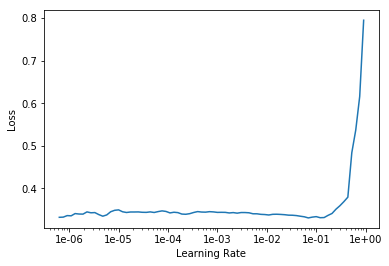

In [18]:
learner.lr_find(); learner.recorder.plot()

In [19]:
learner.fit_one_cycle(30, max_lr=3e-2)

Total time: 00:04
epoch  train_loss  valid_loss  my_acc  
1      0.356582    0.577947    0.748201  (00:00)
2      0.360321    0.576925    0.748201  (00:00)
3      0.356662    0.575458    0.748201  (00:00)
4      0.341612    0.585525    0.748201  (00:00)
5      0.334751    0.574192    0.748201  (00:00)
6      0.331527    0.581774    0.748201  (00:00)
7      0.329802    0.569139    0.748201  (00:00)
8      0.323944    0.584956    0.748201  (00:00)
9      0.319378    0.572765    0.748201  (00:00)
10     0.314556    0.606598    0.748201  (00:00)
11     0.307851    0.592532    0.755396  (00:00)
12     0.299846    0.601209    0.741007  (00:00)
13     0.297417    0.623749    0.748201  (00:00)
14     0.292756    0.622878    0.755396  (00:00)
15     0.290351    0.640245    0.755396  (00:00)
16     0.283117    0.680785    0.748201  (00:00)
17     0.276419    0.602675    0.769784  (00:00)
18     0.276857    0.588216    0.769784  (00:00)
19     0.274952    0.655446    0.762590  (00:00)
20     0.27